# Norm and Dir with CIFAR100
__resnet32x4 and resnet 8x4__

In [1]:
from utils.loss_functions import DKDLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
from torchvision import datasets, transforms, models
import models_package
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
import boto3
import io
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import best_LR, train_teacher, retrieve_teacher_class_weights, new_teacher_class_weights

## Find best LR

In [2]:
# Hyperparameters
learning_rate = 0.003  # 0.01 for resnet34x2 & 0.1 for resnet8 & 0.003 for resnet 8x4
num_epochs = 240
num_workers = 2
batch_size = 16
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

## Load in Data

In [3]:
# Load IdenProf dataset
trainloader, testloader  = load_cifar100(batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Load in models

### resnet32x4_idenprof

In [7]:
# Instantiate the models

# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()

teacher_name = 'resnet32x4_cifar'
teacher_model = models_package.__dict__[teacher_name](num_class=num_classes)
# print(teacher_model.fc.in_features)
teacher_model.fc = nn.Linear(16384, num_classes)

In [9]:
teacher_model

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

### resnet8_idenprof

In [10]:
# teacher_name = 'resnet8_idenprof'
# teacher_model = models_package.__dict__[teacher_name](num_class=10)
# teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)

### resnet8x4_idenprof

In [11]:
student_name = 'resnet8x4_cifar'
student_model = models_package.__dict__[student_name](num_class=num_classes)
# student_model.fc = nn.Linear(student_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(16384, num_classes)

In [12]:
# # Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Best LR

100%|██████████████████████████████████████████████████████████████████████| 3125/3125 [27:14<00:00,  1.91it/s]


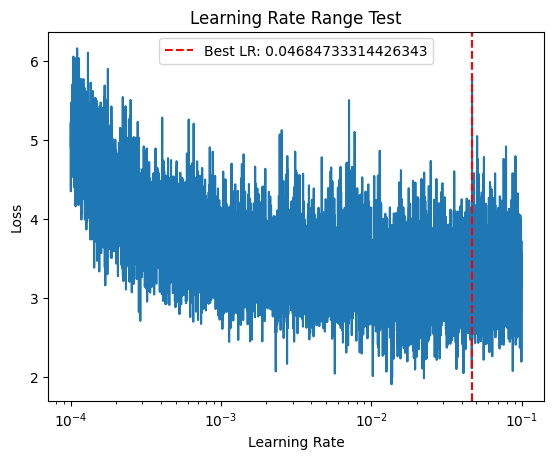

Best learning rate: 0.04684733314426343


0.04684733314426343

In [9]:
teacher_lr = best_LR('resnet32x4_lr', teacher_model, trainloader, 
                     criterion, teacher_optimizer, 
                     teacher_scheduler, num_epochs=3, emb = True)
teacher_lr

100%|██████████████████████████████████████████████████████████████████████| 3125/3125 [06:39<00:00,  7.81it/s]


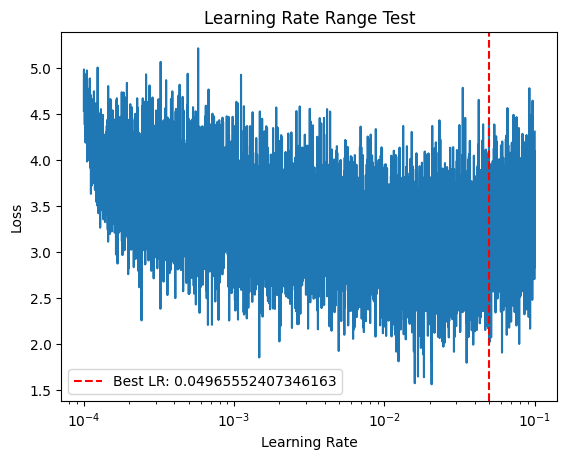

Best learning rate: 0.04965552407346163


0.04965552407346163

In [9]:
student_lr = best_LR('resnet8x4_lr', student_model, trainloader,
                     criterion, student_optimizer, student_scheduler, 
                     num_epochs=3, emb = True)
student_lr

In [13]:
teacher_lr = 0.04684733314426343
student_lr = 0.04965552407346163

In [14]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_lr, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_lr, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Train Leaderboard Teacher Models

In [13]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()


def train_teacher(model_name, model, trainloader, criterion, optimizer, scheduler, num_epochs=240, patience=5):
    ''' A function to train the teacher models'''

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                # print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        
        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(trainloader)):
                val_inputs, val_labels = inputs.to(device), labels.to(device)
                # val_inputs = val_data['img'].to(device)
                # val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                _, val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'*****Epoch {epoch + 1}/{num_epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')

        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            
            # checkpoint
            save_path = './weights/'

            model_save_path = os.path.join(save_path, model_name)
            
            os.makedirs(model_save_path, exist_ok=True)
        
            model_save_name = os.path.join(model_save_path, 'checkpoint.pth')
            mode_weights_name = os.path.join(model_save_path, 'weights.pth')
        
            torch.save(model.state_dict(), mode_weights_name)
            torch.save(model, model_save_name)
            
            # model_save_name = str(save_path + model_name + '/checkpoint.pth')
            # mode_weights_name = str(save_path + model_name + '/weights.pth')

            # torch.save(model.state_dict(), mode_weights_name)
            # torch.save(model, model_save_name)

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")
    plot_loss_curve(val_losses)

In [ ]:
teacher_resnet32x4 = \
    train_teacher('resnet_32x4', teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, num_epochs=260, patience=5)



100%|██████████████████████████████████████████████████████████████████████| 3125/3125 [08:35<00:00,  6.06it/s]


*****Epoch 1/260*****
*****Train Loss:  4.613548 Val Loss:  4.610375*****
*****Validation Accuracy: 1.00%*****



 79%|███████████████████████████████████████████████████████▏              | 2464/3125 [20:40<05:33,  1.98it/s]

In [ ]:
############################# Testing Starts #############################

def train_teacher(model_name, model, trainloader, testloader, criterion, optimizer, scheduler, num_epochs=240, patience=5):
    ''' A function to train and validate the teacher models'''
    best_val_loss = float('inf')
    patience_counter = 0
    val_losses = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                inputs, labels = inputs.to(device), labels.to(device)
                _, outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        avg_val_loss = total_val_loss / len(testloader)
        val_losses.append(avg_val_loss)
        accuracy = total_correct / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {running_loss / len(trainloader):.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save model
            torch.save(model.state_dict(), f'{model_name}_best.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

        scheduler.step()
        model.train()

    # Plot validation losses
    plt.plot(val_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.show()

    return model

# Train the model
teacher_model = train_teacher('resnet32x4_cifar', teacher_model, trainloader, testloader, 
                              criterion, teacher_optimizer, teacher_scheduler,
                              num_epochs=260, patience=5)
############################# Testing Ends #############################

100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 1/260 - Loss: 4.9678, Val Loss: 4.5102, Accuracy: 2.45%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.05it/s]


Epoch 2/260 - Loss: 4.4183, Val Loss: 4.2949, Accuracy: 5.48%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 3/260 - Loss: 4.1661, Val Loss: 4.0336, Accuracy: 9.02%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.05it/s]


Epoch 4/260 - Loss: 3.8903, Val Loss: 3.7526, Accuracy: 14.23%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.05it/s]


Epoch 5/260 - Loss: 3.6875, Val Loss: 3.6308, Accuracy: 16.09%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 6/260 - Loss: 3.5250, Val Loss: 3.4853, Accuracy: 19.15%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 7/260 - Loss: 3.2515, Val Loss: 3.2017, Accuracy: 23.91%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 8/260 - Loss: 3.0176, Val Loss: 3.0640, Accuracy: 26.38%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 9/260 - Loss: 2.8479, Val Loss: 2.9613, Accuracy: 28.64%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.05it/s]


Epoch 10/260 - Loss: 2.6990, Val Loss: 2.8915, Accuracy: 30.21%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 11/260 - Loss: 2.5496, Val Loss: 2.7759, Accuracy: 32.49%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 12/260 - Loss: 2.4047, Val Loss: 2.7138, Accuracy: 33.67%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 13/260 - Loss: 2.2761, Val Loss: 2.7624, Accuracy: 33.42%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.03it/s]


Epoch 14/260 - Loss: 2.1572, Val Loss: 2.6682, Accuracy: 36.27%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 15/260 - Loss: 2.0552, Val Loss: 2.6345, Accuracy: 35.84%


100%|████████████████████████████████████████████████████████████████████████| 625/625 [01:43<00:00,  6.04it/s]


Epoch 16/260 - Loss: 1.9700, Val Loss: 2.6392, Accuracy: 37.25%


 89%|██████████████████████████████████████████████████████████████▎       | 2782/3125 [24:14<02:59,  1.91it/s]

In [ ]:
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_resnet324_cifar100.pth')
torch.save(teacher_model, 'teacher_model_resnet324_cifar100.pth')
print('teacher weights and architecture saved and exported')

# torch.save(student_model.state_dict(), 'student_model_weights_resnet84_wider.pth')
# torch.save(student_model, 'student_model_resnet84_wider.pth')
# print('student weights and architecture saved and exported')

In [ ]:
# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    
    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        # for i, batch in enumerate(tqdm(trainloader)):
        #     inputs, labels = batch['img'].to(device), batch['label'].to(device)
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs[0], labels)
            kd_loss = tkd_kdloss(student_outputs[0], teacher_outputs[0], temperature=temperature)  # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        epoch_losses.append(epoch_loss)

        
        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                val_inputs, val_labels = inputs.to(device), labels.to(device)
                # val_inputs = val_data['img'].to(device)
                # val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                _, val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'*****Epoch {epoch + 1}/{num_epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                val_inputs, val_labels = inputs.to(device), labels.to(device)
                # val_inputs = val_data['img'].to(device)
                # val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                _, val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'*****Epoch {epoch + 1}/{num_epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')


        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [ ]:
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, student_optimizer, 
                                student_scheduler, device, alpha, temperature, num_epochs=240)

In [ ]:
# Save the student and teacher model weights and architecture
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_resnet324_wider.pth')
# torch.save(teacher_model, 'teacher_model_resnet324_wider.pth')
# print('teacher weights and architecture saved and exported')

torch.save(student_model.state_dict(), 'student_model_weights_resnet84_cifar100.pth')
torch.save(student_model, 'student_model_resnet84_cifar100.pth')
print('student weights and architecture saved and exported')

## Extract Class Weights for Norm and Direction

In [8]:
## Load in model and weights
model_path = './weights/resnet_32x4/checkpoint.pth'
weights_path = './weights/resnet_32x4/weights.pth'
test_path = './weights/resnet_32x4/test.pth'
# idenprof_resnet32x4_model = torch.load(weights_path)
# # idenprof_resnet32x4_model.load_state_dict(torch.load(weights_path))
# # idenprof_resnet32x4_model.eval()
# # idenprof_resnet32x4_model.items()

# # import torch, torchvision.models
# # model = torchvision.models.vgg16()
# # path = 'test.pth'
# torch.save(idenprof_resnet32x4_model.state_dict(), test_path) # nothing else here
# idenprof_resnet32x4_model.load_state_dict(torch.load(test_path))

In [9]:
model_name = 'resnet32x4_idenprof'
num_class = 10
model = models_package.__dict__[model_name](num_class=num_class)
checkpoint = torch.load(weights_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KeyError: 'model_state_dict'

In [16]:
print(idenprof_resnet32x4_model)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [5]:
def retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, dataloader, batch_size):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''
    model = models_package.__dict__[model_name](num_class=num_class)
    model_ckpt = models_package.__dict__[model_name](num_class=num_class)
    print('Visualized the embedding feature of the {} model on the train set'.format(model_name))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_ckpt.to(device)
    model_ckpt.load_state_dict(torch.load(model_weight_path))
    model_ckpt.eval()
    new_state_dict = OrderedDict()
    for k, v in model_ckpt.items():
        name = k[7:]   # remove 'module.'
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)
    with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)
    f.close()

In [6]:
retrieve_teacher_class_weights(model_name = 'resnet32x4_idenprof', 
                               model_weight_path = './weights/resnet_32x4/weights.pth', 
                               num_class = 10, 
                               data_name = 'idenprof',
                               dataloader = trainloader, 
                               batch_size = 128
                              )


Visualized the embedding feature of the resnet32x4_idenprof model on the train set


AttributeError: 'ResNet' object has no attribute 'items'

In [4]:
new_teacher_class_weights(model_name = 'resnet32x4_idenprof', 
                               model_weight_path = './weights/resnet_32x4/weights.pth', 
                               num_class = 10, 
                               data_name = 'idenprof',
                               dataloader = trainloader, 
                               batch_size = 128
                              )


Visualized the embedding feature of the resnet32x4_idenprof model on the train set


KeyError: 'model_state_dict'

## Train Leaderboard Student Models

In [ ]:
########## Need studnet model loss function

In [ ]:
# Studnet Model Training

## Save Models and Weights

In [ ]:
## backup
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_resnet8_4.pth')
torch.save(teacher_model, 'testing_teacher_model_resnet8_4.pth')
print('student weights and architecture saved and exported')

In [ ]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_weights_resnet8_4.pth'
teacher_model_path = 'models/testing_teacher_model_resnet8_4.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

# # Student Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# student_model_weights_path = 'weights/student_model_weights.pth' 
# student_model_path = 'models/student_model.pth'

# # Save state dict to buffer
# student_model_weights_buffer = io.BytesIO()
# torch.save(student_model.state_dict(), student_model_weights_buffer)
# student_model_weights_buffer.seek(0)

# # Save entire model to buffer
# student_model_buffer = io.BytesIO()
# torch.save(student_model, student_model_buffer)
# student_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
# print('student weights and architecture saved and exported to S3')

## Read Models and Weights

In [6]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/idenprof_teacher_resnet32x4_weights.pth'
# student_model_weights_s3_path = 'weights/testing_student_model_weights_rkd_prof.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

######## MAKE SURE THAT YOU HAVE THE CORRECT MODELS FOR WEIGHTS ########
# Teacher
# teacher_name = 'resnet8x4_idenprof'
teacher_name = 'resnet32x4_idenprof'
teacher_model = models_package.__dict__[teacher_name](num_class=10)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)
teacher_model.load_state_dict(torch.load(teacher_model_weights_buffer))
teacher_model.eval()
# # Student
# student_model = CustomResNet18()
# student_model.load_state_dict(torch.load(student_model_weights_buffer))


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [13]:
import boto3
import io
import os
import torch
import torch.nn as nn
from collections import OrderedDict
import json
import models_package  
import numpy as np


# # Function definitions


#### without mean
# def get_emb_fea(model, dataloader, batch_size):
#     # Define the device
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
#     model.eval() 
#     embeddings = []

#     with torch.no_grad(): 
#         for data in dataloader:
#             inputs, labels = data
#             inputs = inputs.to(device)

#             output = model(inputs)
#             if isinstance(output, tuple):
#                 output = output[0]

#             embeddings.append(output.cpu().numpy())

#     embeddings = np.concatenate(embeddings, axis=0).tolist() 
#     return embeddings


#### with mean
def get_emb_fea(model, dataloader, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval() 
    class_embeddings = {}

    with torch.no_grad(): 
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.cpu().numpy()

            output = model(inputs)
            if isinstance(output, tuple):
                output = output[0]

            embeddings = output.cpu().numpy()

            for emb, label in zip(embeddings, labels):
                label = int(label)  
                if label not in class_embeddings:
                    class_embeddings[label] = []
                class_embeddings[label].append(emb)

    class_mean_embeddings = {label: np.mean(np.array(embs), axis=0).tolist() 
                             for label, embs in class_embeddings.items()}

    return class_mean_embeddings


#### the original function with a small update
# def get_emb_fea(model, dataloader, batch_size):
#     ''' Used to extract the feature embeddings in a teacher model '''
#     model.eval()

#     EMB = {}

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.cuda(), labels.cuda()

#             # compute output
#             emb_fea, logits = model(images, embed=True)

#             for emb, i in zip(emb_fea, labels):
#                 i = i.item()
#                 emb_size = len(emb) 
#                 if str(i) in EMB:
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))
#                 else:
#                     EMB[str(i)] = [[] for _ in range(emb_size)]
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))

#     for key, value in EMB.items():
#         for i in range(emb_size):
#             EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

#     return EMB

    

def retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    print("Keys in checkpoint:", checkpoint.keys())

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

# Calling the function
model_name = 'resnet32x4_idenprof'
model_weight_path = 'weights/idenprof_teacher_resnet32x4_weights.pth'
num_class = 10
data_name = 'idenprof'  
batch_size = 0  
bucket_name = '210bucket'  

retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, testloader, batch_size, bucket_name)


Keys in checkpoint: odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked'

## LB Help

1. loading in model weights and idenprof dataset from s3 (LB will set up) __COMPLETE__
2. save model weights to s3 bucket (moving forward) __COMPLETE__
3. Teachers: help running resnet-34x2 (LB) -- needs to be trained on idenprof __COMPLETE__
4. Make sure that resnet-8x4 is running __COMPLETE__
5. Student: shufflenet-v1  -- just need to make them run